In [94]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [95]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [96]:
out_files = []
update_list = []

## Helper functions

In [97]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [98]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [99]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [100]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [101]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [102]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [103]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [104]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [105]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [106]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [107]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [108]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [109]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [110]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [111]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [112]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [113]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read cell type hierarchy

In [114]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [115]:
cd4_search_id = 'yttrium-lutetium-gallium'

In [116]:
cd8_search_id = 'meitnerium-indium-bromine'

In [117]:
other_t_search_id = 'thallium-americium-moscovium'

Retrieve files stored in our HISE project store

In [118]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [119]:
search_string = '|'.join([cd4_search_id, cd8_search_id, other_t_search_id])
search_df = ps_df[ps_df['name'].str.contains(search_string)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [120]:
search_df['AIFI_L3'].tolist()

['CD8aa',
 'CM CD8 T cell',
 'Core naive CD8 T cell',
 'GZMK- CD27+ EM CD8 T cell',
 'GZMK+ CD27+ EM CD8 T cell',
 'ISG+ memory CD8 T cell',
 'ISG+ naive CD8 T cell',
 'KLRF1- GZMB+ CD27- EM CD8 T cell',
 'KLRF1+ GZMB+ CD27- EM CD8 T cell',
 'SOX4+ naive CD8 T cell',
 'CD4 MAIT',
 'CD8 MAIT',
 'DN T cell',
 'GZMB+ Vd2 gdT',
 'GZMK+ Vd2 gdT',
 'GZMK+ memory CD4 Treg',
 'ISG+ MAIT',
 'KLRB1+ memory CD4 Treg',
 'KLRB1+ memory CD8 Treg',
 'KLRF1- effector Vd1 gdT',
 'KLRF1+ effector Vd1 gdT',
 'Memory CD4 Treg',
 'Memory CD8 Treg',
 'Naive CD4 Treg',
 'Naive Vd1 gdT',
 'Proliferating T cell',
 'SOX4+ Vd1 gdT',
 'CM CD4 T cell',
 'Core naive CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'ISG+ memory CD4 T cell',
 'ISG+ naive CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'SOX4+ naive CD4 T cell']

## Retrieve CD8 cells to check for co-clustering of CD8+ cells in CD4 populations

In [121]:
n_per_type = 20000

In [122]:
cd8_types = [
    'CM CD8 T cell',
    'Core naive CD8 T cell',
    'GZMK- CD27+ EM CD8 T cell',
    'GZMK+ CD27+ EM CD8 T cell',
    'KLRF1- GZMB+ CD27- EM CD8 T cell',
    'KLRF1+ GZMB+ CD27- EM CD8 T cell',
    'SOX4+ naive CD8 T cell'
]

In [123]:
cd8_list = []
for cd8_type in cd8_types:
    print(cd8_type)
    type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cd8_type].tolist()[0]
    adata = read_adata_uuid(type_uuid)
    print(adata.shape)
    if adata.shape[0] > n_per_type:
        adata = sc.pp.subsample(adata, n_obs = n_per_type, copy = True)
    print(adata.shape)
    cd8_list.append(adata)

CM CD8 T cell
(220612, 33538)
(20000, 33538)
Core naive CD8 T cell
(750067, 33538)
(20000, 33538)
GZMK- CD27+ EM CD8 T cell
(35167, 33538)
(20000, 33538)
GZMK+ CD27+ EM CD8 T cell
(545335, 33538)
(20000, 33538)
KLRF1- GZMB+ CD27- EM CD8 T cell
(497683, 33538)
(20000, 33538)
KLRF1+ GZMB+ CD27- EM CD8 T cell
(179176, 33538)
(20000, 33538)
SOX4+ naive CD8 T cell
(19624, 33538)
(19624, 33538)


In [124]:
for i in range(len(cd8_list)):
    cd8_list[i].obs['group'] = 'CD8'

## Extract CD8+ cells from CD4 

In [129]:
cd4_types = [
    'KLRF1- GZMB+ CD27- memory CD4 T cell',
    'Core naive CD4 T cell',
    'CM CD4 T cell',
    'GZMB- CD27- EM CD4 T cell',
    'GZMB- CD27+ EM CD4 T cell',
]

In [130]:
cd4_list = []
for cd4_type in cd4_types:
    print(cd4_type)
    type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cd4_type].tolist()[0]
    adata = read_adata_uuid(type_uuid)
    print(adata.shape)

    ## Extract CD8A+ clusters
    cd8_adata, n_extracted = extract_cl(
        adata, 'CD8A', 'above', 0.4, 'leiden_2'
    )
    cd8_adata.obs['group'] = 'CD8pos CD4'
    print(cd8_adata.shape)
    cd4_list.append(cd8_adata)

    ## Sample CD8A- cells as a reference
    adata, n_extracted = remove_cl(
        adata, 'CD8A', 'above', 0.4, 'leiden_2'
    )
    if adata.shape[0] > n_per_type:
        adata = sc.pp.subsample(adata, n_obs = n_per_type, copy = True)
    adata.obs['group'] = 'CD4'
    print(adata.shape)
    cd4_list.append(adata)

KLRF1- GZMB+ CD27- memory CD4 T cell
(160915, 33538)
['17']
(4605, 33538)
['17']
(20000, 33538)
Core naive CD4 T cell
(2704765, 33538)
[]
(0, 33538)
[]
(20000, 33538)
CM CD4 T cell
(1424598, 33538)
['12']
(62120, 33538)
['12']
(20000, 33538)
GZMB- CD27- EM CD4 T cell
(534020, 33538)
['12']
(26498, 33538)
['12']
(20000, 33538)
GZMB- CD27+ EM CD4 T cell
(609365, 33538)
['13']
(18242, 33538)
['13']
(20000, 33538)


## Add Tregs

In [131]:
treg_types = [
    'Memory CD4 Treg',
    'Memory CD8 Treg'
]

In [132]:
treg_list = []
for treg_type in treg_types:
    print(treg_type)
    type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == treg_type].tolist()[0]
    adata = read_adata_uuid(type_uuid)
    print(adata.shape)
    if adata.shape[0] > n_per_type:
        adata = sc.pp.subsample(adata, n_obs = n_per_type, copy = True)
    adata.obs['group'] = 'Treg'
    print(adata.shape)
    treg_list.append(adata)

Memory CD4 Treg
(143652, 33538)
(20000, 33538)
Memory CD8 Treg
(2756, 33538)
(2756, 33538)


## Assemble and jointly process

In [133]:
joint_adata = sc.concat(cd8_list + cd4_list + treg_list)
joint_adata

AnnData object with n_obs × n_vars = 373845 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_2', 'AIFI_L3', 'AIFI_L3_score', 'group'
    obsm: 'X_pca', 'X_umap'

In [134]:
joint_adata = process_adata(joint_adata)

Normalizing; Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; 

IOStream.flush timed out


Renormalizing


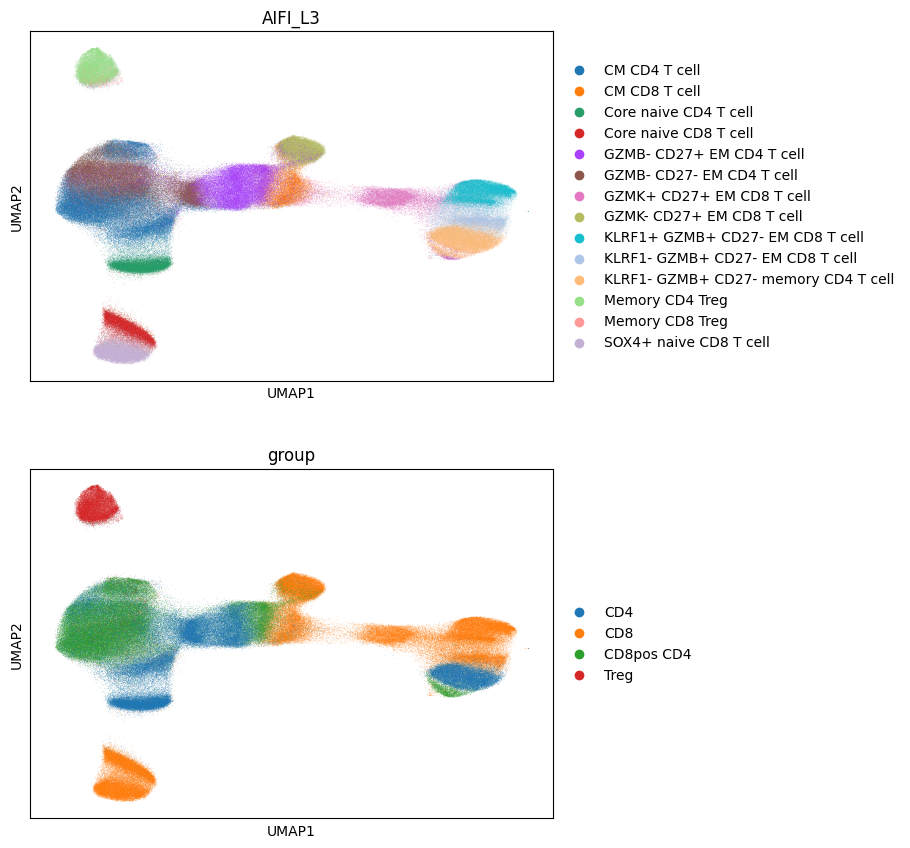

In [135]:
sc.pl.umap(joint_adata, color = ['AIFI_L3', 'group'], ncols = 1)

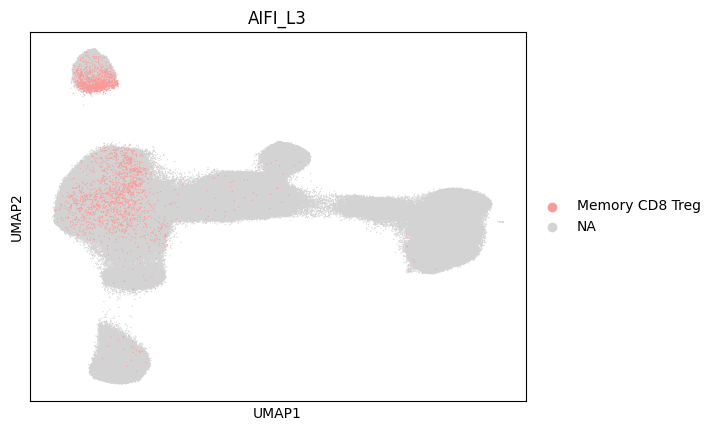

In [148]:
sc.pl.umap(joint_adata, color = ['AIFI_L3'], ncols = 1, groups = 'Memory CD8 Treg', size = 3)

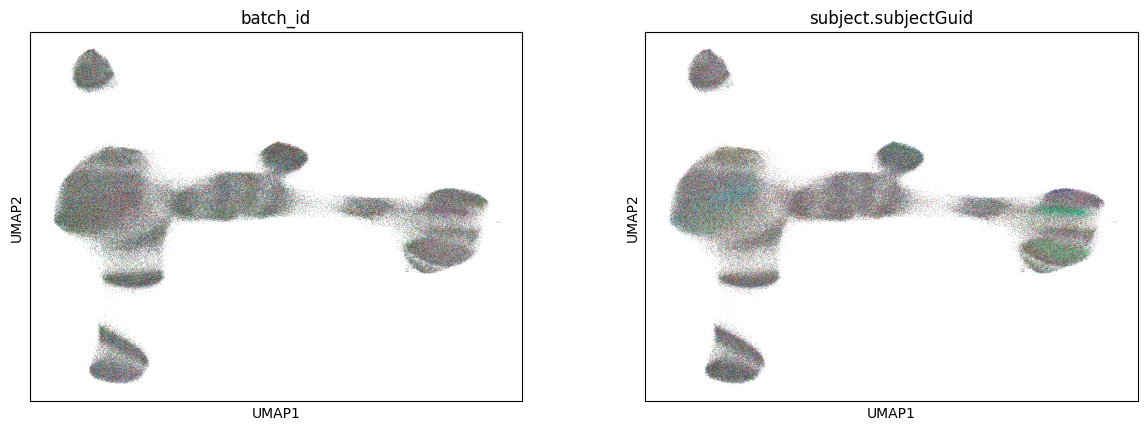

In [136]:
sc.pl.umap(joint_adata, color = ['batch_id','subject.subjectGuid'], legend_loc = 'none')

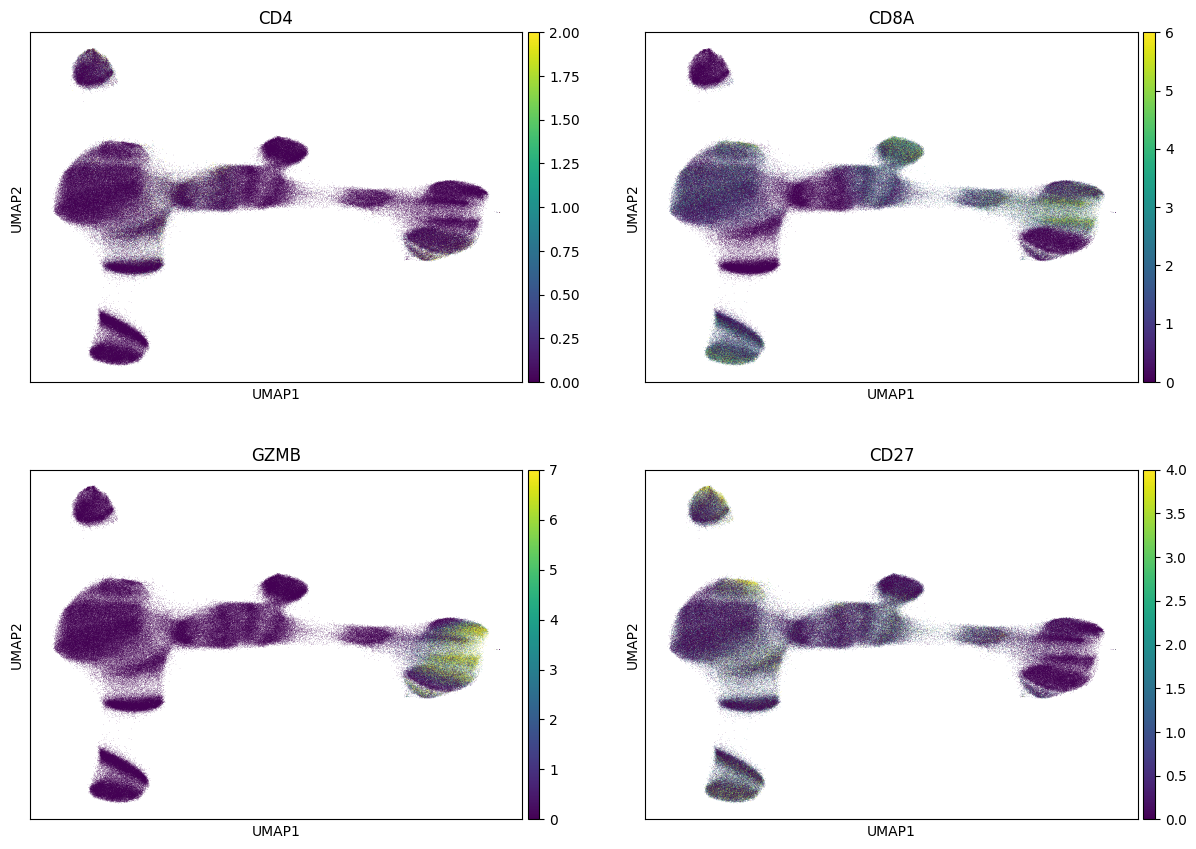

In [137]:
sc.pl.umap(joint_adata, color = ['CD4', 'CD8A', 'GZMB', 'CD27'],
           ncols = 2, vmax = 'p98')

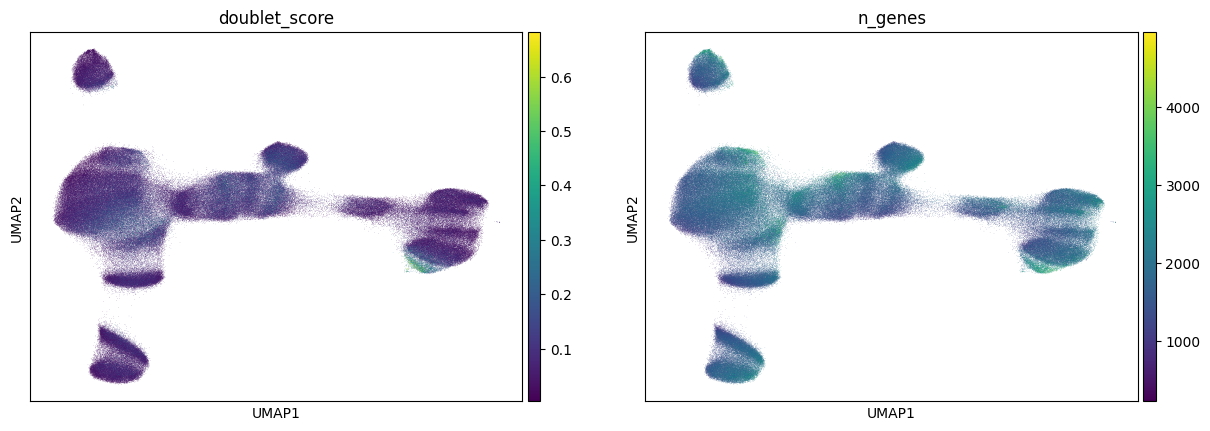

In [138]:
sc.pl.umap(joint_adata, color = ['doublet_score', 'n_genes'])

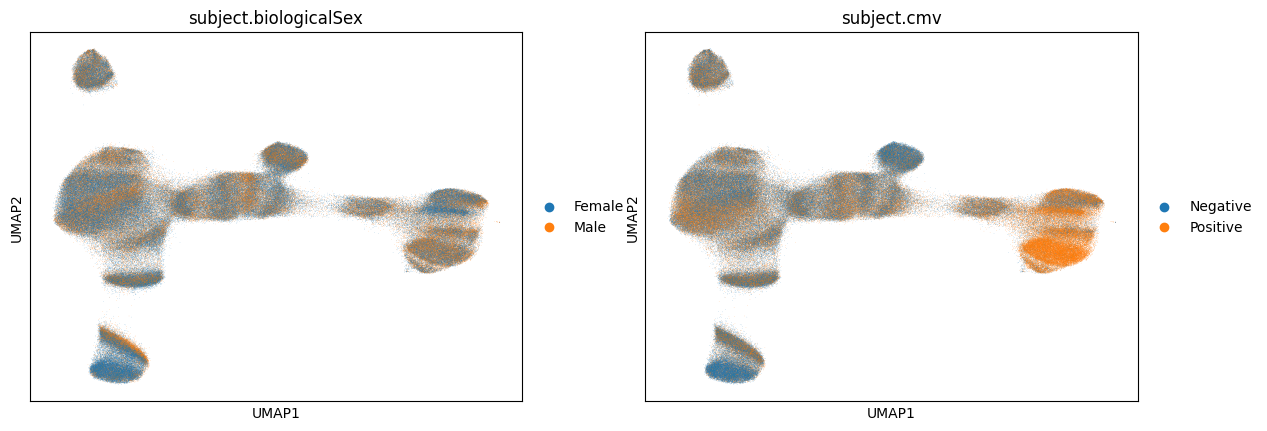

In [139]:
sc.pl.umap(joint_adata, color = ['subject.biologicalSex', 'subject.cmv'])

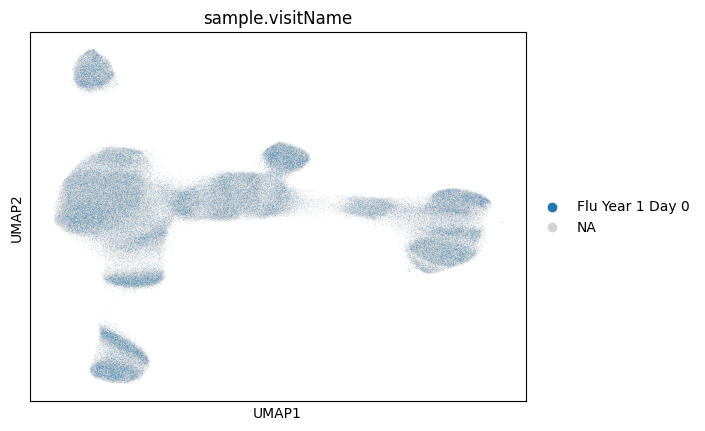

In [157]:
sc.pl.umap(joint_adata, color = ['sample.visitName'], groups = ['Flu Year 1 Day 0', 'Flu Year 1 Day 0'])

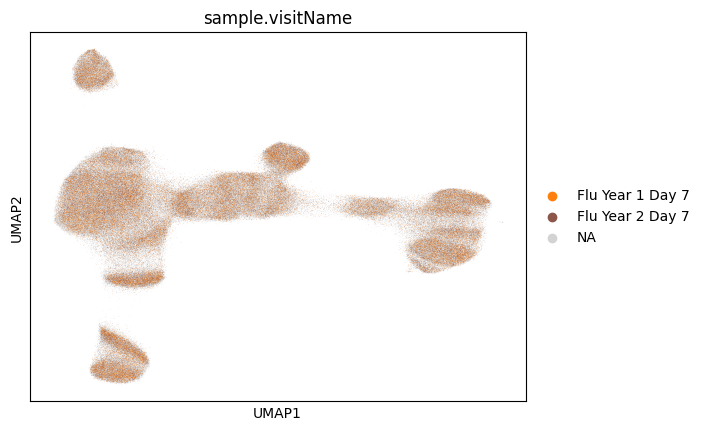

In [155]:
sc.pl.umap(joint_adata, color = ['sample.visitName'], groups = ['Flu Year 1 Day 7', 'Flu Year 2 Day 7'])

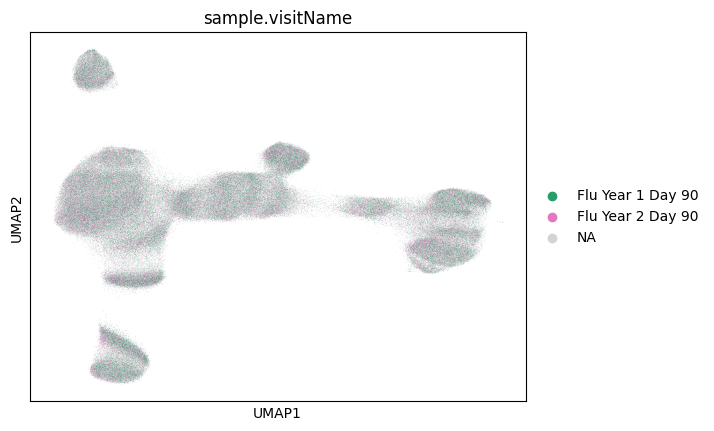

In [158]:
sc.pl.umap(joint_adata, color = ['sample.visitName'], groups = ['Flu Year 1 Day 90', 'Flu Year 2 Day 90'])

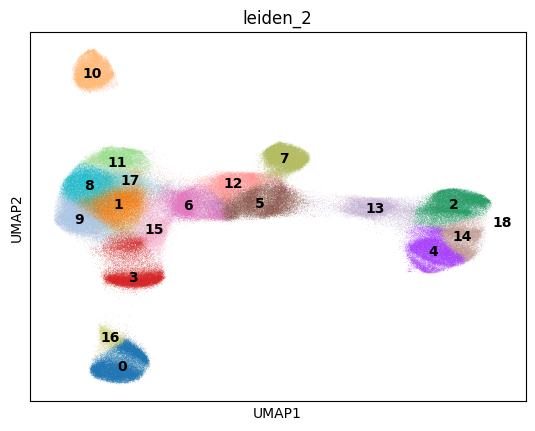

In [140]:
sc.pl.umap(joint_adata, color = 'leiden_2', legend_loc = 'on data')

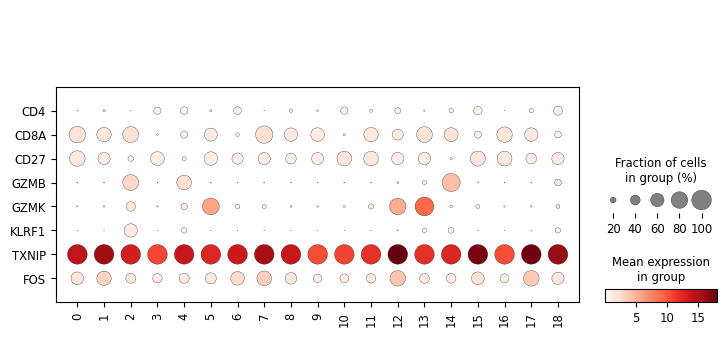

In [141]:
sc.pl.dotplot(
    joint_adata,
    groupby = 'leiden_2',
    var_names = ['CD4','CD8A','CD27','GZMB', 'GZMK', 'KLRF1','TXNIP', 'FOS'],
    swap_axes = True
)

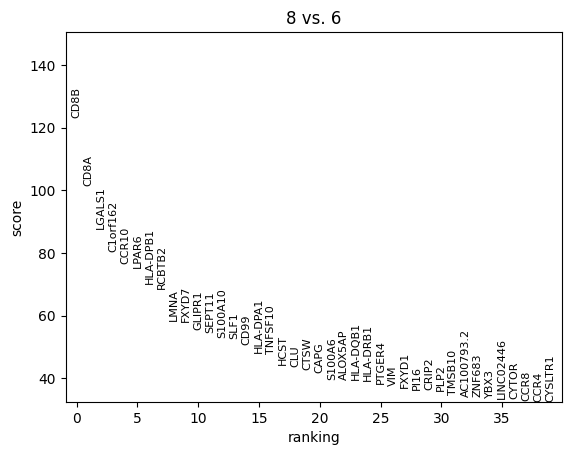

In [153]:
sc.tl.rank_genes_groups(
    joint_adata, 
    groupby = 'leiden_2', 
    groups = ['8'],
    reference = '6'
)
sc.pl.rank_genes_groups(joint_adata, n_genes = 40)

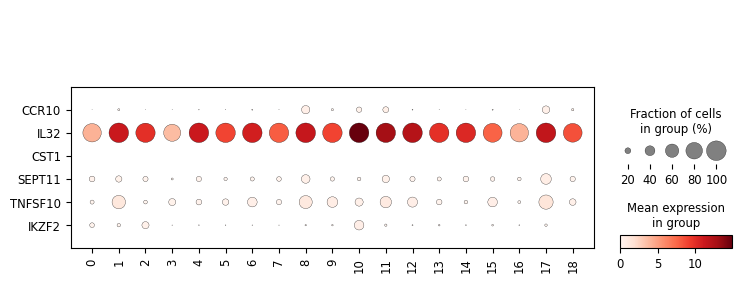

In [152]:
sc.pl.dotplot(
    joint_adata,
    groupby = 'leiden_2',
    var_names = ['CCR10', 'IL32', 'CST1', 'SEPT11', 'TNFSF10','IKZF2'],
    swap_axes = True
)

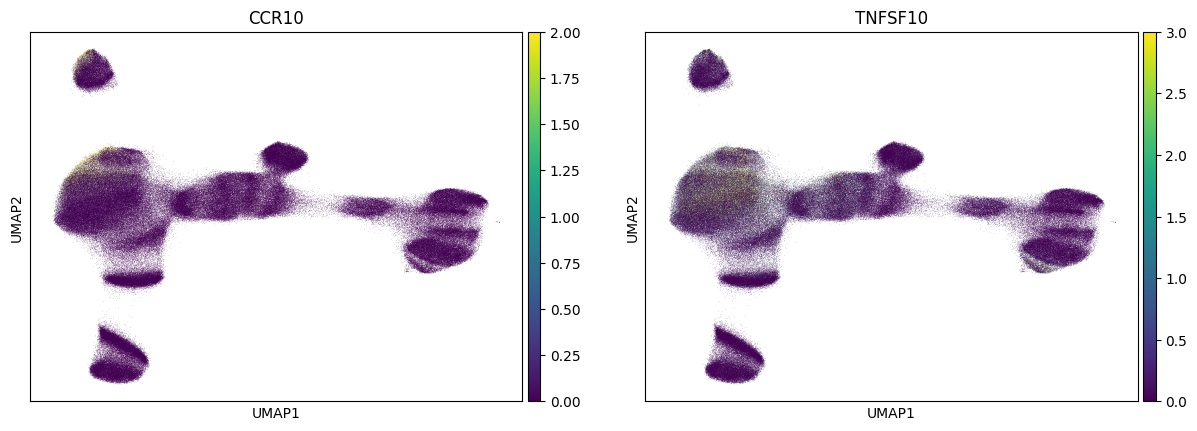

In [150]:
sc.pl.umap(joint_adata, color = ['CCR10','TNFSF10'],
           ncols = 2, vmax = 'p98')

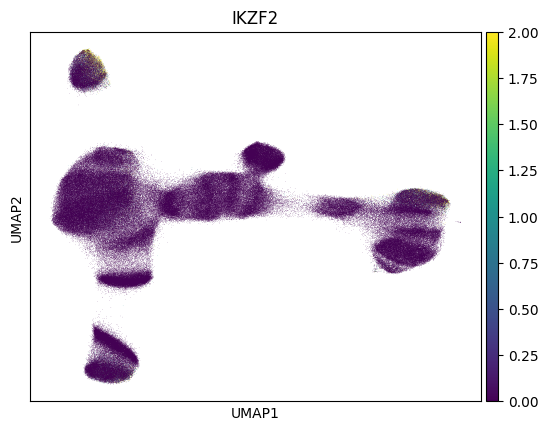

In [151]:
sc.pl.umap(joint_adata, color = ['IKZF2'],
           ncols = 2, vmax = 'p98')

## Recommended transfers

GZMB- CD27+ EM CD4 T cells -> CM CD8 T cells looks good.

In [159]:
out_file = 'output/diha_cd8a_from_cd4_t_cells_{d}'.format(d = date.today())
adata.write_h5ad(out_file)

## Upload data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [160]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CD8A+ cells from CD4 types {d}'.format(d = date.today())

In [161]:
search_id = element_id()
search_id

'platinum-selenium-aluminum'

In [165]:
in_files = search_df['id'].loc[search_df['AIFI_L3'].isin(cd8_types + cd4_types + treg_types)].tolist()
in_files

['2896f047-ba25-4337-8a35-dc2cea67c9eb',
 'e6b4cad1-4548-4dc5-94b4-92f446f202cf',
 '635578f6-3f75-481f-bb05-7d2c19380472',
 '7eaa5234-22d6-4b80-829e-a28b6355c1da',
 '9b17ab97-d536-40ca-9010-dfc6df5016d6',
 '13510ff7-50f9-4624-8afa-83605a562b93',
 '5c186814-d463-41d8-bd6c-d14d6a912617',
 '59959bb2-b20a-4d1b-acb5-5a048ed3986f',
 'bc8acf20-7748-4107-9912-c3fcfe8929a3',
 '38827e4d-4b66-43eb-9d5a-1e749ffc38d2',
 'c1a418fe-1bd0-49f1-b9b5-47916d239ca9',
 'b17c91af-2017-4476-84a3-59a5bbe0ecb4',
 '94e9d829-0757-4266-b8a1-2b4b59b1f67e',
 '1252fd26-a9a6-41a6-b983-a796eee75c5c']

In [166]:
out_files = [out_file]

In [167]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12z-Python_filter_L3_cd4_cd8_transfer.ipynb
2) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12g-Python_filter_L3_other_data.ipynb
3) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12a-Python_filter_L3_b_cell_data.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/diha_cd8a_from_cd4_t_cells_2024-04-22']. Do you truly want to proceed?


(y/n) y


{'trace_id': '0dab4b62-b5e9-4bd1-949e-ed30fcbaa545',
 'files': ['output/diha_cd8a_from_cd4_t_cells_2024-04-22']}

In [168]:
import session_info
session_info.show()